<a href="https://colab.research.google.com/github/igsgo/Smart-Factory-Digital-Shadow-Throughput-Optimization-Energy-Analysis/blob/main/Smart_Factory_Digital_Shadow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Objective**

The main of this project is to apply Machine Learning techniques to analyze operational data from a decentralized manufacturing system. By leveraging shop floor data, this notebook aims to:



*   ***Predict critical KPIs*** (such as Cycle Time or Quality Status) based o stochastic process variables.
*   ***Identify Bottlenecks:*** Use feature importance analysis to understand which variables (e.g, Machine Temperatura, Energy Consumption) have the highest impact on production efficiency.
*  ***Suport Decision Making:*** Demonstrate how data mining can transition from simple monitoring to predictive production control.






**Methodology**



*   ***Data Source:*** Decentralized Smart Factory Operational Data.
*   ***Algorithm:***
*   ***Focus:*** Bridging the gap between Mechanical Engineering principles and Data Science.



**Downloading the Dataset**

In [2]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("zoya77/decentralized-smart-factory-operational-data")
arquivos = os.listdir(path)
csv_files = [f for f in arquivos if f.endswith('.csv')]

arquivo_correto = os.path.join(path, csv_files[0])
df = pd.read_csv(arquivo_correto)
df.head()

100%|██████████| 75.7k/75.7k [00:00<00:00, 31.9MB/s]

Extracting files...


,Hour,Machine_ID,Temperature_Sensor,Vibration_Level,Power_Consumption,Production_Rate,PID_Kp,PID_Ki,PID_Kd,Error_Deviation,...,Anomaly_Score,Federated_Model_Version,Sensor_Status,Feedback_Signal_Smoothed,Block_Validation_Time,Smart_Contract_Triggered,Resource_Utilization,Demand_Response,Supply_to_Demand,Supply
0,6,4,57.865268,3.461859,34.641218,21,1.411628,0.037526,0.280068,0.642812,...,0.147958,2,1,-0.378912,131.160190,0,42.843152,23.297297,0.917852,21.383469
1,14,3,73.031601,2.700677,93.548578,82,0.942952,0.250637,0.224708,-0.667642,...,0.984654,1,0,-1.554036,76.149409,0,33.202976,55.583155,1.657383,92.122592
2,10,5,56.753486,3.073726,70.838405,48,0.704901,0.464284,0.421198,-1.558205,...,0.209097,2,0,-2.027913,70.192895,1,78.989442,54.493355,1.026866,55.957360
3,7,4,39.223144,3.187034,54.644305,93,1.477460,0.061643,0.088733,-2.430208,...,0.130353,2,0,-3.245210,109.677080,0,43.440774,68.655448,1.717972,117.948153
4,6,3,44.979796,2.266957,11.144340,85,1.607896,0.384576,0.022236,-1.110489,...,0.203535,2,1,-1.423128,98.317344,0,88.583130,54.253013,0.979282,53.129008


**Getting info from the dataset**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Hour                      500 non-null    int64  
 1   Machine_ID                500 non-null    int64  
 2   Temperature_Sensor        500 non-null    float64
 3   Vibration_Level           500 non-null    float64
 4   Power_Consumption         500 non-null    float64
 5   Production_Rate           500 non-null    int64  
 6   PID_Kp                    500 non-null    float64
 7   PID_Ki                    500 non-null    float64
 8   PID_Kd                    500 non-null    float64
 9   Error_Deviation           500 non-null    float64
 10  Control_Signal            500 non-null    float64
 11  Latency                   500 non-null    float64
 12  Anomaly_Score             500 non-null    float64
 13  Federated_Model_Version   500 non-null    int64  
 14  Sensor_Sta

**Data Preprocessing**

**1. Feature Selection**

We can remove the Machine ID and Hour columns, because it doesn't matter for the physics analysis.





In [5]:
drop_cols = [target_col, 'Machine_ID','Hour']
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['Production_Rate']

**2. Handling Missing Values**

We know that this current dataset have no missing values, but for a real life problem it might have some missing values that we need to clean to keep the production system stability.

In [6]:
from sklearn.impute import SimpleImputer
if X.isna().sum().sum() > 0:
  imputer = SimpleImputer(strategy = 'mean')
  X_imputed = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
else:
  print(f"Dataset is clean!")
  X_imputed = X.copy()

Dataset is clean!


**3. Scaling**

Probably, we're gonna have to compare 2 or more models to see which one has the better accuracy for our problem. So, we're gonna normalize the data to ensure a fair comparison

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_imputed, y, test_size = 0.2, random_state = 42)

X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test_raw), columns = X.columns)

**Now it's time to compare the models**

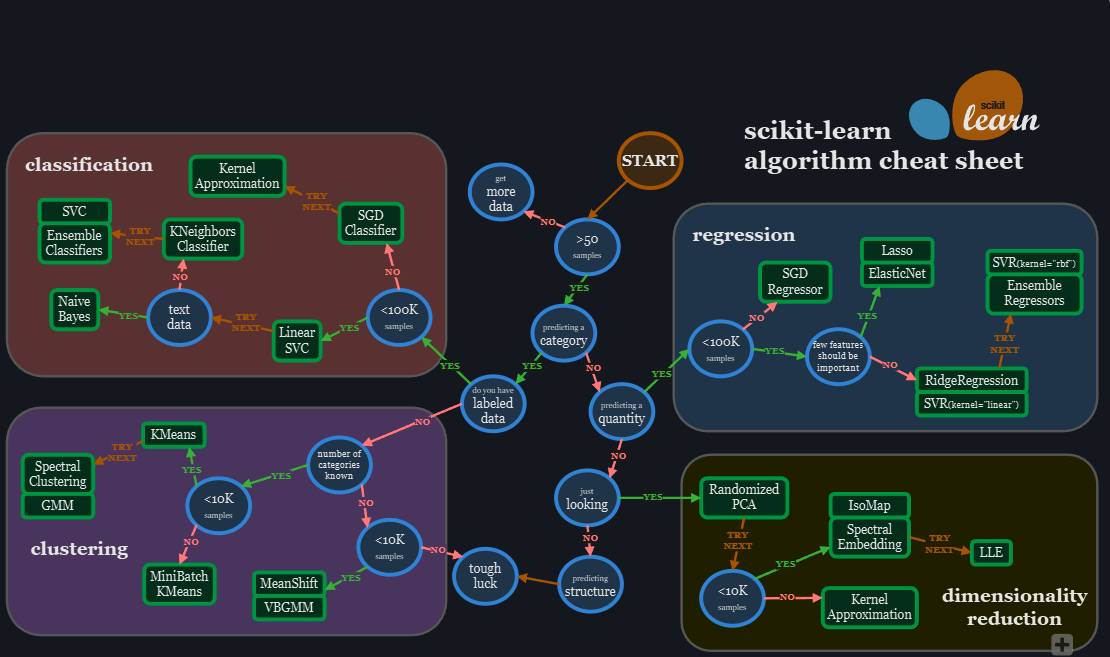

Following the path in the image, the best models to use are either: **RidgeRegression**,**SVR** or **XGBoost (one of the Ensemble Regressors)**. Let's compare their MAE and R² Score.

In [18]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import xgboost as xgb

models = {
    "Ridge Regression": Ridge (alpha = 1.0),
    "SVR (RBF Kernel)": SVR(C=1.0, epsilon = 0.1),
    "XGBoost (Ensemble Regressors)": xgb.XGBRegressor(objective='reg:squarederror',n_estimators = 100, random_state = 42)
}

results = {}

for name, model in models.items():
  model.fit(X_train,y_train)
  preds = model.predict(X_test)

  mae = mean_absolute_error(y_test, preds)
  r2 = r2_score(y_test, preds)

  results[name]= mae

  print (f"Model: {name}")
  print(f"   -> Mean Absolute Error (MAE): {mae:.4f}")
  print(f"   -> R² Score: {r2:.4f}")
  print("="*30)

best_model = min(results, key = results.get)
print(f"Best Model: {best_model}")

Model: Ridge Regression
   -> Mean Absolute Error (MAE): 6.8640
   -> R² Score: 0.9146
Model: SVR (RBF Kernel)
   -> Mean Absolute Error (MAE): 21.6584
   -> R² Score: 0.2601
Model: XGBoost (Ensemble Regressors)
   -> Mean Absolute Error (MAE): 8.8511
   -> R² Score: 0.8656
Best Model: Ridge Regression


**The Ridge Regression model fits the best for our problem, let's check which coefficient is positive or negative for the Production Rate**

/tmp/ipython-input-3728963162.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=coefficients, palette='coolwarm')


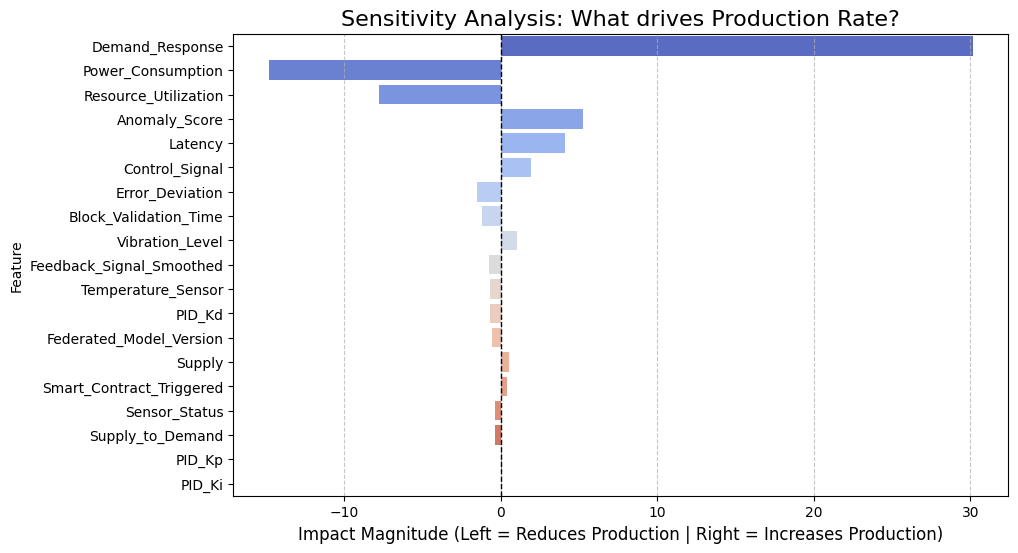


>>> KEY FINDING:
The most critical variable is 'Demand_Response'.
Mathematical Insight: For every unit increase in Demand_Response, the Production Rate INCREASES by 30.17 units.


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

winner_model = models["Ridge Regression"]

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Weight': winner_model.coef_
})

coefficients ['Absolute Importance'] = coefficients['Weight'].abs()
coefficients = coefficients.sort_values(by = 'Absolute Importance', ascending = False)

plt.figure(figsize=(10, 6))

sns.barplot(x='Weight', y='Feature', data=coefficients, palette='coolwarm')

plt.title('Sensitivity Analysis: What drives Production Rate?', fontsize=16)
plt.xlabel('Impact Magnitude (Left = Reduces Production | Right = Increases Production)', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

top_feature = coefficients.iloc[0]['Feature']
top_weight = coefficients.iloc[0]['Weight']
direction = "INCREASES" if top_weight > 0 else "DECREASES"

print(f"\n>>> KEY FINDING:")
print(f"The most critical variable is '{top_feature}'.")
print(f"Mathematical Insight: For every unit increase in {top_feature}, the Production Rate {direction} by {abs(top_weight):.2f} units.")

The sensitivity analysis reveals that the factory operates as a demand-driven system, with ***Demand_Response*** being the strongest positive driver (+30.17) of the Production Rate. Conversely, ***Power_Consumption*** acts as the primary bottleneck (-15.0), indicating that energy inefficiencies or peak load conditions significantly penalize throughput. Surprisingly, control parameters ***(PID)*** showed negligible impact, suggesting that the process stability is well-managed, and future optimization efforts should focus on Energy Efficiency and Logistics rather than machine-level tuning.

**Let's also check the equation that dictates this factory**

In [23]:
model = models["Ridge Regression"]
intercepto = model.intercept_

termos = sorted(zip(model.coef_, X.columns), key=lambda x: abs(x[0]), reverse=True)

print ("-> Factory's Equation:")
print("="*30)
print(f"Production_Rate = {intercepto:.2f}")
for peso, nome in termos:
    sinal = "+" if peso >= 0 else "-"
    print(f"   {sinal} ({abs(peso):.2f} * {nome})")

-> Factory's Equation:
Production_Rate = 68.85
   + (30.17 * Demand_Response)
   - (14.81 * Power_Consumption)
   - (7.79 * Resource_Utilization)
   + (5.30 * Anomaly_Score)
   + (4.15 * Latency)
   + (1.97 * Control_Signal)
   - (1.53 * Error_Deviation)
   - (1.18 * Block_Validation_Time)
   + (1.07 * Vibration_Level)
   - (0.75 * Feedback_Signal_Smoothed)
   - (0.69 * Temperature_Sensor)
   - (0.66 * PID_Kd)
   - (0.55 * Federated_Model_Version)
   + (0.54 * Supply)
   + (0.40 * Smart_Contract_Triggered)
   - (0.32 * Sensor_Status)
   - (0.32 * Supply_to_Demand)
   + (0.12 * PID_Kp)
   + (0.02 * PID_Ki)
